## Bring in libraries and dataframes and set indexes

In [132]:
import datetime
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import ETFunctions
%matplotlib inline
from statsmodels.formula.api import ols
from statsmodels.stats.anova import anova_lm
import statsmodels.api as sm
import matplotlib.dates as mdates
import GraphHelpers as GH

In [133]:
WaterDelta = pd.read_pickle('.\DataFrames\ProfileWaterDelta.pkl')
WaterDelta.columns = WaterDelta.columns.swaplevel('Irrigation','Cultivar')
GH.SortFrame(WaterDelta)

In [134]:
GPs = GH.SetGraphicsPatterns(WaterDelta.columns,
                    ['--','-'],
                    [0.45,0.15],
                    ['^','o'],
                    ['blue','red','green'])

Cultivar
['Dash', 'Omaka']
Irrigation
['High', 'Low', 'Mid']
Treatments
MultiIndex(levels=[['Dash', 'Omaka'], ['High', 'Low', 'Mid']],
           labels=[[0, 0, 0, 1, 1, 1], [0, 1, 2, 0, 1, 2]])
Styles
[('--', 'blue', 0.45, '^'), ('--', 'red', 0.45, '^'), ('--', 'green', 0.45, '^'), ('-', 'blue', 0.15, 'o'), ('-', 'red', 0.15, 'o'), ('-', 'green', 0.15, 'o')]
StyleFrame
           Lin    Col   Alp Mar    MFC
Dash  High  --   blue  0.45   ^   blue
      Low   --    red  0.45   ^    red
      Mid   --  green  0.45   ^  green
Omaka High   -   blue  0.15   o  white
      Low    -    red  0.15   o  white
      Mid    -  green  0.15   o  white


## investigate how much upward flux we are getting at night

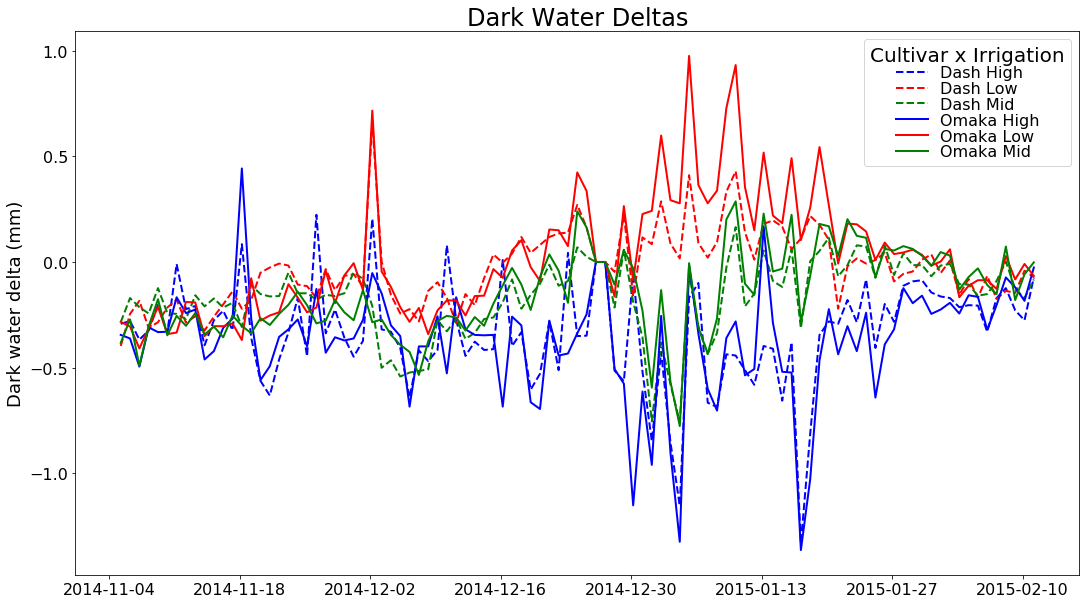

In [135]:
DarkWaterDeltas = WaterDelta.iloc[WaterDelta.index.indexer_between_time(datetime.time(23),datetime.time(4))]
DarkWaterDeltas = DarkWaterDeltas.resample('24H', base=5).sum()#Base of 5 means sampling from 6am to 6am
MeanDarkWaterDeltas = DarkWaterDeltas.groupby(level=['Cultivar','Irrigation'],axis=1).mean()
Graph = plt.figure(figsize=(18,10))
ax = Graph.add_subplot(1,1,1)
GH.AddIndexedPlot(MeanDarkWaterDeltas,ax,GPs,2)
GH.AddLegend(1,18,"Cultivar x Irrigation")
GH.SetAxProps(title='Dark Water Deltas',titsize=24,
              ylab='Dark water delta (mm)',labsize = 18,
              ticsize = 16)

## Work out Irrigation timings and amounts.

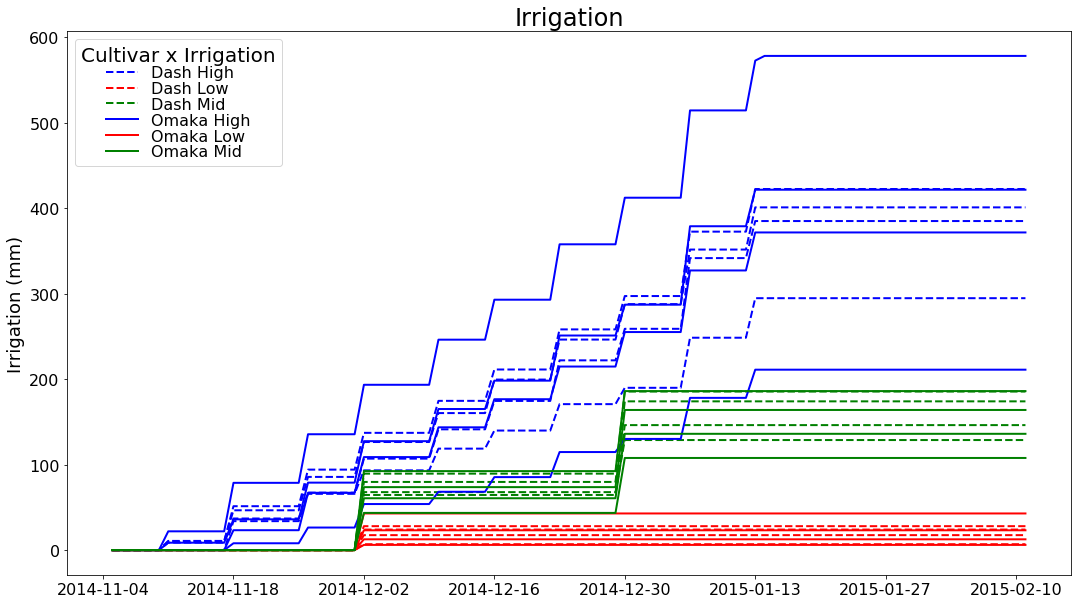

In [136]:
Irrigation = WaterDelta.where(WaterDelta > 3)
Irrigation = Irrigation.resample('D').sum()
Irrigation.fillna(0, inplace = True)
AccumIrrig = Irrigation.cumsum()
#AccumIrrig.plot( figsize=(18,10), style=['b-','b-','b-','b-','b--','b--','b--','b--','r-','r-','r-','r-','r--','r--','r--','r--','g-','g-','g-','g-','g--','g--','g--','g--'])
Graph = plt.figure(figsize=(18,10))
ax = Graph.add_subplot(1,1,1)
GH.AddIndexedPlot(AccumIrrig,ax,GPs,2)
GH.AddLegend(2,18,"Cultivar x Irrigation")
GH.SetAxProps(title='Irrigation',titsize=24,
              ylab='Irrigation (mm)',labsize = 18,
              ticsize = 16)

In [137]:
Irrigation.to_pickle('.\DataFrames\Irrigation.pkl')

In [138]:
HighIrrigIndex = Irrigation.where(Irrigation > 0).dropna(how='all').index.tolist()
del HighIrrigIndex[-1:]

In [139]:
LowIrrIndex = pd.to_datetime('2014-12-02 00:00:00')
MidIrrIndex = pd.to_datetime(['2014-12-02 00:00:00','2014-12-23 00:00:00'])
HighIrrigIndex = pd.to_datetime(['2014-11-11 00:00:00',
 '2014-11-18 00:00:00',
 '2014-11-26 00:00:00',
 '2014-12-02 00:00:00',
 '2014-12-10 00:00:00',
 '2014-12-16 00:00:00',
 '2014-12-23 00:00:00',
 '2014-12-30 00:00:00',
 '2015-01-06 00:00:00',
 '2015-01-14 00:00:00'])

In [140]:
DSIyesterday = 0

DaysSinceIrrigation = pd.DataFrame(index = Irrigation.index, columns = Irrigation.columns)
for col in range(DaysSinceIrrigation.columns.size):
    for x in range(Irrigation.index.size):
        if x == 0:
            DaysSinceIrrigation.iloc[x,col] = float(0)
        else: 
            if Irrigation.iloc[x,col] == 0:
                DaysSinceIrrigation.iloc[x,col] = float(DaysSinceIrrigation.iloc[x-1,col]+1)
            else:
                DaysSinceIrrigation.iloc[x,col] = float(0)

## Whats causing the big negatives in the irrigated treatments, is it drainage following irrigation or dark water extraction following high ET day or night time transpiration??

### Bring in some variables that may explain it

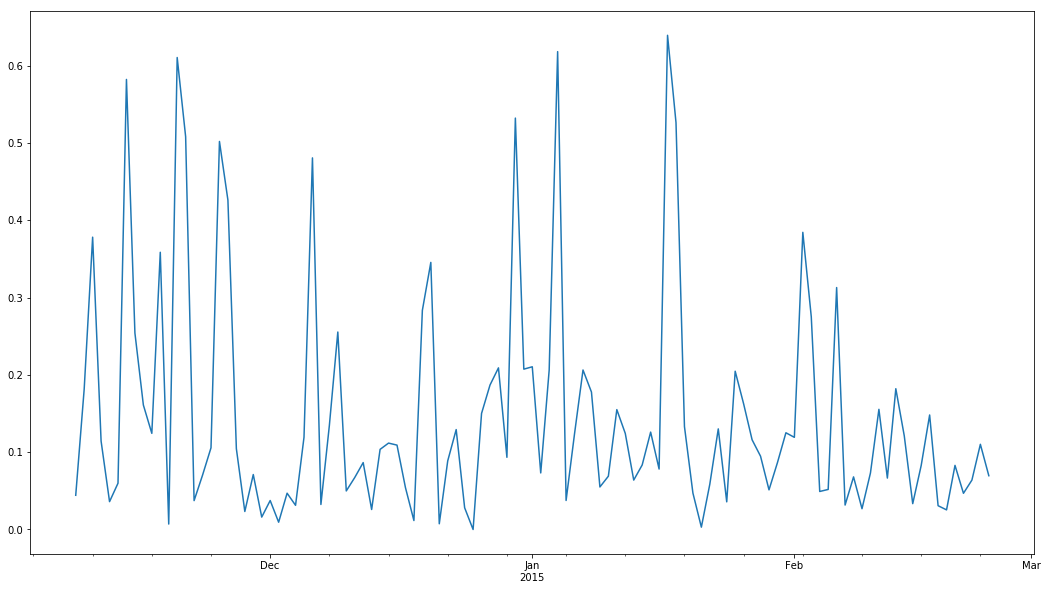

In [141]:
#Bring in night time PET data
NightTimePETAtmospheric = pd.read_pickle('.\DataFrames/NightTimePET.pkl')
NightTimePETAtmospheric.index = NightTimePETAtmospheric.index.normalize()
NightTimePETAtmospheric = NightTimePETAtmospheric.loc['2014-11-08':] #Drop of the first day because it only has a part nights numbers and no day associated wit it
NightTimePETAtmospheric.plot(figsize=(18,10))

In [142]:
NightTimeSoilHeatFlux = pd.read_pickle('.\DataFrames\SoilHeatFluxNightEst.pkl')
NightTimeSoilHeatFlux_mm = np.divide(NightTimeSoilHeatFlux,2.4)

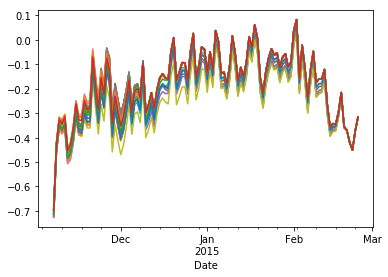

In [143]:
NightTimeSoilHeatFlux_mm.plot(legend=False)

In [144]:
DayTimePET = pd.read_pickle('.\DataFrames\DayTimePET.pkl')
DayTimePET.index = DayTimePET.index.normalize()

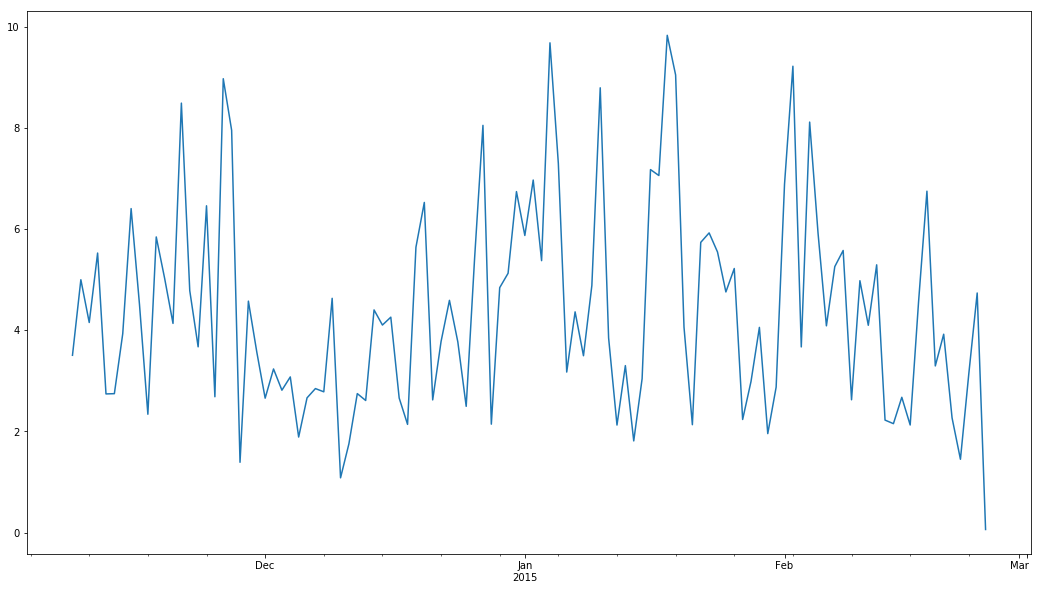

In [145]:
DayTimePET.plot(figsize=(18,10))

## Stick the Dark water delta into a data frame with the things that might explain it and do a multiple regression

In [146]:
SWD = pd.read_pickle('.\DataFrames\DailySWD.pkl')

In [147]:
Cultivars = ['Dash','Omaka']
Irrigations = ['Low', 'Mid','High']

LongData = MeanDarkWaterDeltas.loc['2014-11-08':,:]
LongData.index = LongData.index.normalize()
LongData = LongData.unstack()
LongData = pd.DataFrame(LongData, columns=['DarkDeltas'])
#multiply Gnight by -1 to make positive (potential evaporation as apposed to negative heat gain)
LongData.loc[:,'Gnight'] = NightTimeSoilHeatFlux_mm.loc['2014-11-08':'2015-02-11',:].groupby(level=('Cultivar','Irrigation'),axis=1).mean().unstack().multiply(-1)
LongData.loc[:,'SWD'] = SWD.loc['2014-11-08':'2015-02-11',:].groupby(level=('Cultivar','Irrigation'),axis=1).mean().unstack()
for Cult in Cultivars:
    for Irr in Irrigations:
        LongData.loc[(Cult,Irr),'PETAtmoNight'] = NightTimePETAtmospheric.loc['2014-11-08':'2015-02-11'].values
        LongData.loc[(Cult,Irr),'PETAtmoDay'] = DayTimePET.loc['2014-11-08':'2015-02-11'].values
        LongData.loc[(Cult,Irr),'DSI'] = DaysSinceIrrigation.loc['2014-11-08':'2015-02-11',(Cult,Irr)].mean(axis=1).values
LongData.loc[:,'PETnight'] = LongData.loc[:,'Gnight']+LongData.loc[:,'PETAtmoNight']
LongData.loc[:,'IntSWD_PETnight'] = LongData.loc[:,'SWD']*LongData.loc[:,'PETnight']
LongData.loc[:,'IntSWD_Gnight'] = LongData.loc[:,'SWD']*LongData.loc[:,'Gnight']
LongData.loc[:,'IntSWD_PETAtmoNight'] = LongData.loc[:,'SWD']*LongData.loc[:,'PETAtmoNight']
LongData.loc[:,'IntSWD_PETDay'] = LongData.loc[:,'SWD']*LongData.loc[:,'PETAtmoDay']

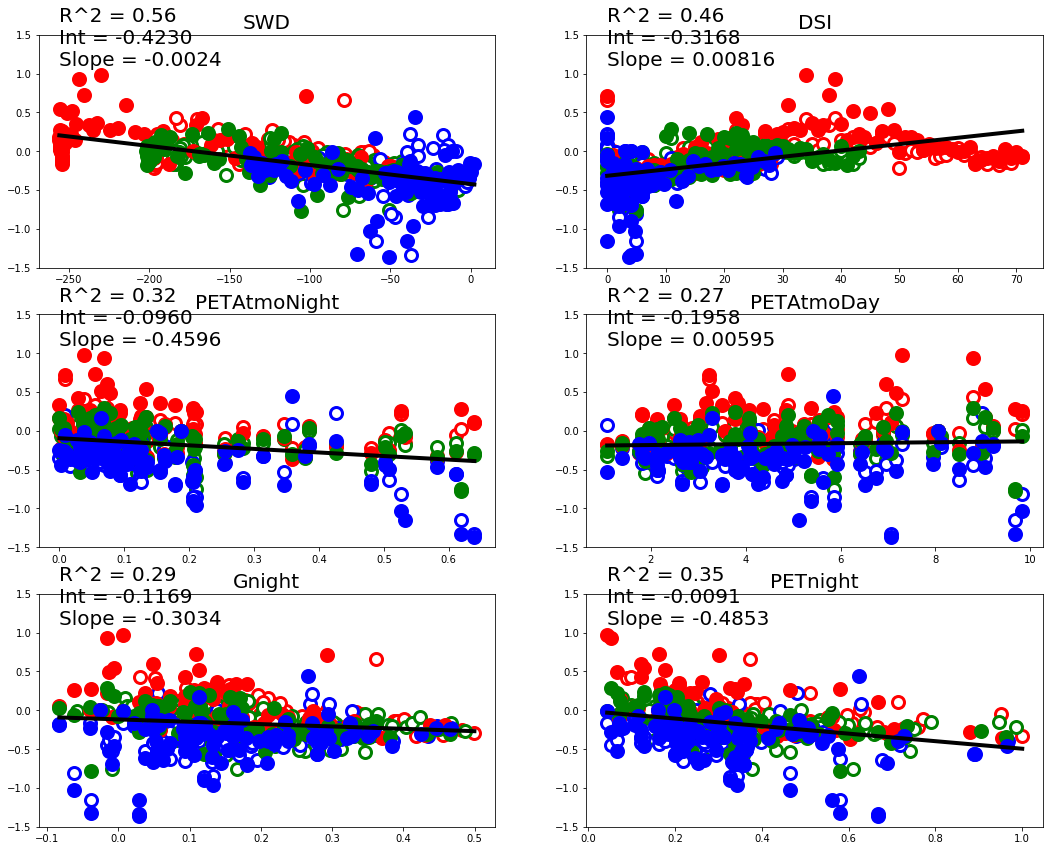

<Figure size 1296x720 with 0 Axes>

In [148]:
Graph = plt.figure(figsize=(18,30))
plt.figure(figsize=(18,10))
ecols = ['r','g','b','r','g','b']
fcols = ['w','w','w','r','g','b']
pannel = 1
Descriptors = [ 'SWD', 'DSI', 'PETAtmoNight','PETAtmoDay','Gnight','PETnight']
for des in Descriptors:
    DailyDescriptor = LongData.loc[:,des]
    fig = Graph.add_subplot(6,2,pannel)
    pos = 0
    for cul in Cultivars:
        for irr in Irrigations:
            fig.plot(LongData.loc[(cul,irr),des].loc['2014-11-08':],
                LongData.loc[(cul,irr),'DarkDeltas'].loc['2014-11-08':],
                     'o',mec=ecols[pos],mfc=fcols[pos],mew = 3, markersize = 12,)
            pos+=1  
    
    X = LongData.loc[:,LongData.columns.isin([des])]
    Y = LongData.loc[:,'DarkDeltas']
    ModTemp = sm.regression.linear_model.OLS(Y,  # Y variable
                                            sm.add_constant(X), # X variable
                                            missing='drop',                                     # ignor and data where one value is missing
                                            hasconst=False) 
    Regres = ModTemp.fit(); 
    Xs = []
    Xs.append(X.min())
    Xs.append(X.max())
    Ys = []
    Ys.append(Regres.params[0] + Xs[0]*Regres.params[1])
    Ys.append(Regres.params[0] + Xs[1]*Regres.params[1])
    fig.plot(Xs,Ys,'-', linewidth = 4, color='k')
    fitR2 = 'R^2 = ' + str(Regres.rsquared)[:4] + '\nInt = ' + str(Regres.params[0])[:7] + '\nSlope = ' + str(Regres.params[1])[:7]
    fig.text(X.min(),1.1,fitR2,fontsize=20)
    fig.set_ylim(-1.5,1.5)
    fig.set_title(des, fontsize = 20)
    pannel +=1

In [149]:
Descriptors = ['SWD']
X = LongData.loc[:,LongData.columns.isin(Descriptors)]
Y = LongData.loc[:,'DarkDeltas']
ModTemp = sm.regression.linear_model.OLS(Y,  # Y variable
                                        sm.add_constant(X), # X variable
                                        missing='drop',                                     # ignor and data where one value is missing
                                        hasconst=False) 
Regres = ModTemp.fit(); 
Regres.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:             DarkDeltas   R-squared:                       0.567
Model:                            OLS   Adj. R-squared:                  0.566
Method:                 Least Squares   F-statistic:                     372.5
Date:                Fri, 23 Nov 2018   Prob (F-statistic):          4.49e-104
Time:                        08:17:14   Log-Likelihood:                 76.003
No. Observations:                 570   AIC:                            -148.0
Df Residuals:                     568   BIC:                            -139.3
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const         -0.4231      0.016    -26.852      0.000      -0.454      -0.392
SWD           -0.0025      0.000    -19.415      0.000      -0.003      -0.002
==============================================================================
Omnibus:                       91.860   Durbin-Watson:                   1.196
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              706.823
Skew:                          -0.441   Prob(JB):                    3.28e-154
Kurtosis:                       8.384   Cond. No.                         221.
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [150]:
Descriptors = ['SWD','PETAtmoday']
X = LongData.loc[:,LongData.columns.isin(Descriptors)]
Y = LongData.loc[:,'DarkDeltas']
ModTemp = sm.regression.linear_model.OLS(Y,  # Y variable
                                        sm.add_constant(X), # X variable
                                        missing='drop',                                     # ignor and data where one value is missing
                                        hasconst=False) 
Regres = ModTemp.fit(); 
Regres.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:             DarkDeltas   R-squared:                       0.567
Model:                            OLS   Adj. R-squared:                  0.566
Method:                 Least Squares   F-statistic:                     372.5
Date:                Fri, 23 Nov 2018   Prob (F-statistic):          4.49e-104
Time:                        08:17:14   Log-Likelihood:                 76.003
No. Observations:                 570   AIC:                            -148.0
Df Residuals:                     568   BIC:                            -139.3
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const         -0.4231      0.016    -26.852      0.000      -0.454      -0.392
SWD           -0.0025      0.000    -19.415      0.000      -0.003      -0.002
==============================================================================
Omnibus:                       91.860   Durbin-Watson:                   1.196
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              706.823
Skew:                          -0.441   Prob(JB):                    3.28e-154
Kurtosis:                       8.384   Cond. No.                         221.
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

### Some things are clear from first glance.  SWD is having a strong influence on dark water deltas.  this makes sense because when the soil is wet there will be flux below out of the bottom and when it is dry there into the bottom of the profile.  So a large part of the dark water deltas can be attributed to unsaturated fluxes over the bottom of the profile.  Assumably these will be the same at day as they are at night and need to be accounted for in the water balance.
### There is a relationship between SWD and DSI.  Lets investigate that further

Text(0,0.5,'DSI (d)')

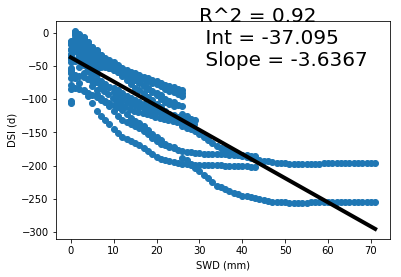

In [151]:
X = LongData.loc[:,'DSI'].loc['2014-11-08':]
Y = LongData.loc[:,'SWD'].loc['2014-11-08':]
plt.plot(X,Y,'o')

ModTemp = sm.regression.linear_model.OLS(Y,  # Y variable
                                        sm.add_constant(X), # X variable
                                        missing='drop',                                     # ignor and data where one value is missing
                                        hasconst=False) 
Regres = ModTemp.fit(); 
Xs = []
Xs.append(X.min())
Xs.append(X.max())
Ys = []
Ys.append(Regres.params[0] + Xs[0]*Regres.params[1])
Ys.append(Regres.params[0] + Xs[1]*Regres.params[1])
plt.plot(Xs,Ys,'-', linewidth = 4, color='k')
fitR2 = 'R^2 = ' + str(Regres.rsquared)[:4] + '\n Int = ' + str(Regres.params[0])[:7] + '\n Slope = ' + str(Regres.params[1])[:7]
plt.text(30,-50,fitR2,fontsize=20)
plt.xlabel('SWD (mm)')
plt.ylabel('DSI (d)')

## SWD and DSI are highly correlated so it is the SWD that is causing the relationship between DSI and dark water deltas.  Some non-linearity between dark water deltas and DSI would indicate saturated drainage, dropping away soon after irrigation but this was not apparent so we can not attribute any of the dark water deltas to drainage. 

## There were also positive effects from darkPETatmo and Gdark (and the sum of these, PETnight).  Lets take a closer look at them

In [152]:
#Calculate residuals from SWD relationship and look at how well other things explain
LongData.loc[:,'EstDarkDeltas'] = -0.427 + LongData.loc[:,'SWD'] * -0.0024
LongData.loc[:,'ResDarkDeltas'] = LongData.loc[:,'DarkDeltas'] - LongData.loc[:,'EstDarkDeltas']

Text(0,0.5,'Gnight (mm)')

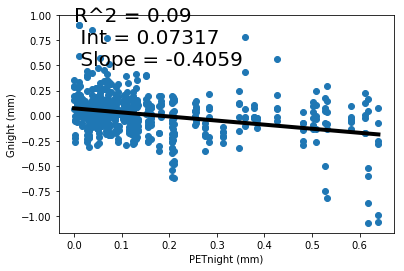

In [153]:
X = LongData.loc[:,'PETAtmoNight'].loc['2014-11-08':]
Y = LongData.loc[:,'ResDarkDeltas'].loc['2014-11-08':]
plt.plot(X,Y,'o')

ModTemp = sm.regression.linear_model.OLS(Y,  # Y variable
                                        sm.add_constant(X), # X variable
                                        missing='drop',                                     # ignor and data where one value is missing
                                        hasconst=False) 
Regres = ModTemp.fit(); 
Xs = []
Xs.append(X.min())
Xs.append(X.max())
Ys = []
Ys.append(Regres.params[0] + Xs[0]*Regres.params[1])
Ys.append(Regres.params[0] + Xs[1]*Regres.params[1])
plt.plot(Xs,Ys,'-', linewidth = 4, color='k')
fitR2 = 'R^2 = ' + str(Regres.rsquared)[:4] + '\n Int = ' + str(Regres.params[0])[:7] + '\n Slope = ' + str(Regres.params[1])[:7]
plt.text(X.min(),0.5,fitR2,fontsize=20)
plt.xlabel('PETnight (mm)')
plt.ylabel('Gnight (mm)')

Text(0,0.5,'Gnight (mm)')

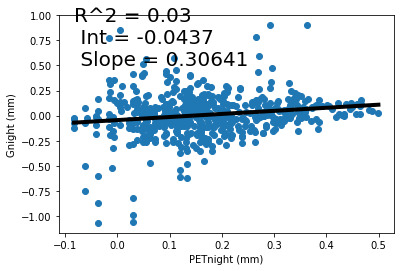

In [154]:
X = LongData.loc[:,'Gnight'].loc['2014-11-08':]
Y = LongData.loc[:,'ResDarkDeltas'].loc['2014-11-08':]
plt.plot(X,Y,'o')

ModTemp = sm.regression.linear_model.OLS(Y,  # Y variable
                                        sm.add_constant(X), # X variable
                                        missing='drop',                                     # ignor and data where one value is missing
                                        hasconst=False) 
Regres = ModTemp.fit(); 
Xs = []
Xs.append(X.min())
Xs.append(X.max())
Ys = []
Ys.append(Regres.params[0] + Xs[0]*Regres.params[1])
Ys.append(Regres.params[0] + Xs[1]*Regres.params[1])
plt.plot(Xs,Ys,'-', linewidth = 4, color='k')
fitR2 = 'R^2 = ' + str(Regres.rsquared)[:4] + '\n Int = ' + str(Regres.params[0])[:7] + '\n Slope = ' + str(Regres.params[1])[:7]
plt.text(X.min(),0.5,fitR2,fontsize=20)
plt.xlabel('PETnight (mm)')
plt.ylabel('Gnight (mm)')

Text(0,0.5,'Gnight (mm)')

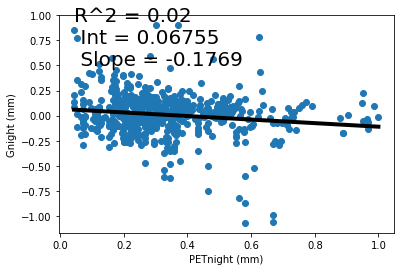

In [155]:
X = LongData.loc[:,'PETnight'].loc['2014-11-08':]
Y = LongData.loc[:,'ResDarkDeltas'].loc['2014-11-08':]
plt.plot(X,Y,'o')

ModTemp = sm.regression.linear_model.OLS(Y,  # Y variable
                                        sm.add_constant(X), # X variable
                                        missing='drop',                                     # ignor and data where one value is missing
                                        hasconst=False) 
Regres = ModTemp.fit(); 
Xs = []
Xs.append(X.min())
Xs.append(X.max())
Ys = []
Ys.append(Regres.params[0] + Xs[0]*Regres.params[1])
Ys.append(Regres.params[0] + Xs[1]*Regres.params[1])
plt.plot(Xs,Ys,'-', linewidth = 4, color='k')
fitR2 = 'R^2 = ' + str(Regres.rsquared)[:4] + '\n Int = ' + str(Regres.params[0])[:7] + '\n Slope = ' + str(Regres.params[1])[:7]
plt.text(X.min(),0.5,fitR2,fontsize=20)
plt.xlabel('PETnight (mm)')
plt.ylabel('Gnight (mm)')

### Thiss give a sensible pattern of fluxes where then are about 1 at the start of the trial and become progressively higher for the Low and more negative for the Full treatments as time progresses

In [156]:
UpwardFlux = DarkWaterDeltas.copy()
UpwardFlux.index = UpwardFlux.index.normalize()
for plot in  UpwardFlux:
    AdjustedFlux = UpwardFlux.loc[:,plot].values
    AdjustedFlux = np.add(AdjustedFlux,NightTimePETAtmospheric.reindex(UpwardFlux.index).values) # Add in the amount of evaporation that would have been replaced
    #AdjustedFlux = np.subtract(AdjustedFlux,NightTimeSoilHeatFlux_mm.loc[UpwardFlux.index,plot].fillna(0))
    UpwardFlux.loc[:,plot] = AdjustedFlux
UpwardFlux = UpwardFlux.multiply(4)  # Multiply by 4 assuming upflux during the day were the same as at night
UpwardFlux.fillna(0, inplace = True)
MeanUpwardFlux = UpwardFlux.groupby(level=['Cultivar','Irrigation'],axis=1).mean()

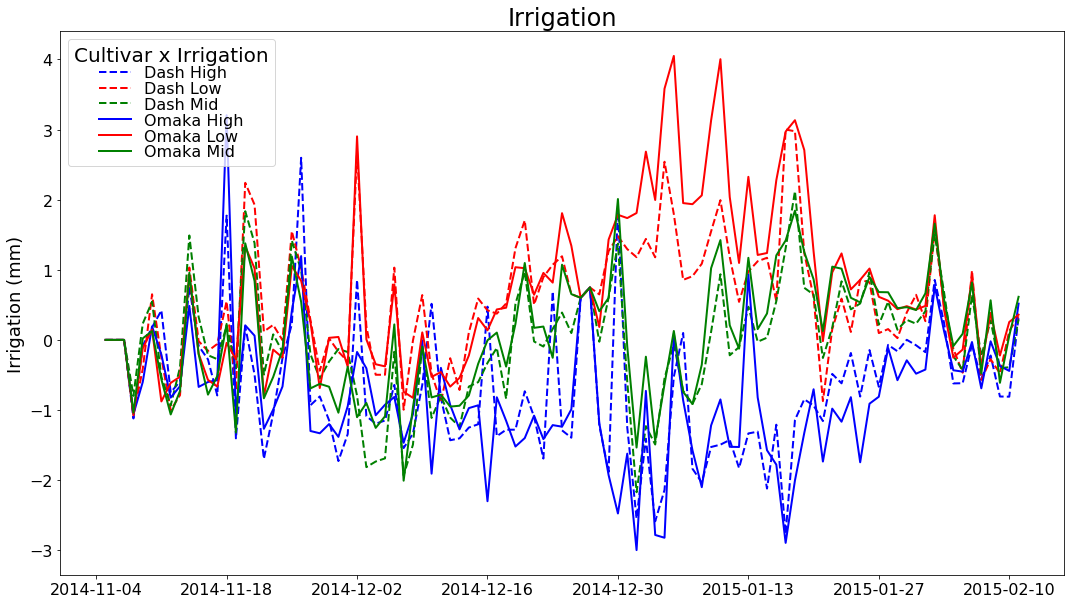

In [157]:
AccumUpFlux = MeanUpwardFlux.cumsum()
Graph = plt.figure(figsize=(18,10))
ax = Graph.add_subplot(1,1,1)
GH.AddIndexedPlot(MeanUpwardFlux,ax,GPs,2)
GH.AddLegend(2,18,"Cultivar x Irrigation")
GH.SetAxProps(title='Irrigation',titsize=24,
              ylab='Irrigation (mm)',labsize = 18,
              ticsize = 16)

# Calculate hourly water use values

## Calculate profile water content deltas for each 1 hour measurement period

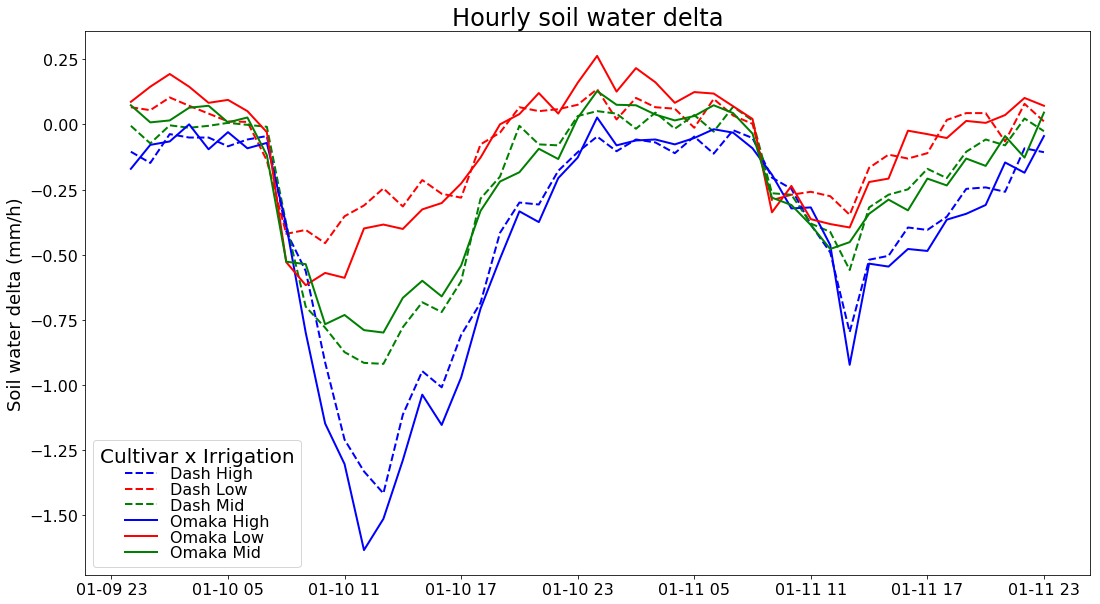

In [158]:
WaterDeltaHourly = WaterDelta.resample('h').sum()
MeanWaterDeltaHourly = WaterDeltaHourly.groupby(level=['Cultivar','Irrigation'],axis=1).mean()
SEMWaterDeltaHourly = WaterDeltaHourly.groupby(level=['Cultivar','Irrigation'],axis=1).std()/np.sqrt(4)
Graph = plt.figure(figsize=(18,10))
ax = Graph.add_subplot(1,1,1)
GH.AddIndexedPlot(MeanWaterDeltaHourly.loc['2015-01-10':'2015-01-11'],ax,GPs,2)
GH.AddLegend(3,18,"Cultivar x Irrigation")
GH.SetAxProps(title='Hourly soil water delta',titsize=24,
              ylab='Soil water delta (mm/h)',labsize = 18,
              ticsize = 16)

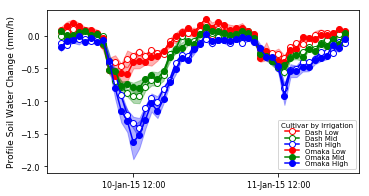

In [159]:
WaterDeltaHourly = WaterDelta.resample('h').sum()
MeanWaterDeltaHourly = WaterDeltaHourly.groupby(level=['Irrigation', 'Cultivar'],axis=1).mean()
SEMWaterDeltaHourly = WaterDeltaHourly.groupby(level=['Irrigation', 'Cultivar'],axis=1).std()/np.sqrt(4)
Start = '2015-01-10'
End = '2015-01-11'
Cultivars = ['Dash','Omaka']
Irrigations = ['Low', 'Mid', 'High']
colors = ['r','b']
cultColors = ['w','w','w','r','g','b']
irrigColors = ['r','g','b','r','g','b']
alphas = [0.2,0.3]
fig, ax = plt.subplots(figsize=(5.6,3))
CulPos = 0
for Cul in Cultivars:
    IrrPos = 0
    for Irr in Irrigations:
        Ind = MeanWaterDeltaHourly.loc[Start:End,(Irr,Cul)].index
        Med = MeanWaterDeltaHourly.loc[Start:End,(Irr,Cul)]
        SEM = SEMWaterDeltaHourly.loc[Start:End,(Irr,Cul)]
        Upp = Med + SEM
        Low = Med - SEM
        plt.fill_between(Ind,Upp,Low,color = irrigColors[IrrPos],alpha=0.3)
        plt.plot(Ind,Med,'o-',mec=irrigColors[IrrPos], mfc = cultColors[CulPos],label = Cul + ' ' + Irr,color=irrigColors[IrrPos])
        IrrPos += 1
        CulPos+=1
        
plt.ylabel('Profile Soil Water Change (mm/h)',fontsize=9)
ax.xaxis.set_major_locator(mdates.HourLocator(12))
ax.xaxis.set_major_formatter(mdates.DateFormatter('%d-%b-%y %H:%M'))
plt.tick_params(labelsize=8)
plt.ylim(-2.1,0.4)

ledg = plt.legend(loc=4,numpoints=1,fontsize = 7,labelspacing = 0.05, 
                          title='Cultivar by Irrigation')
ledg.get_title().set_fontsize(7)
plt.savefig('Fig_#.jpg',dpi=1000)

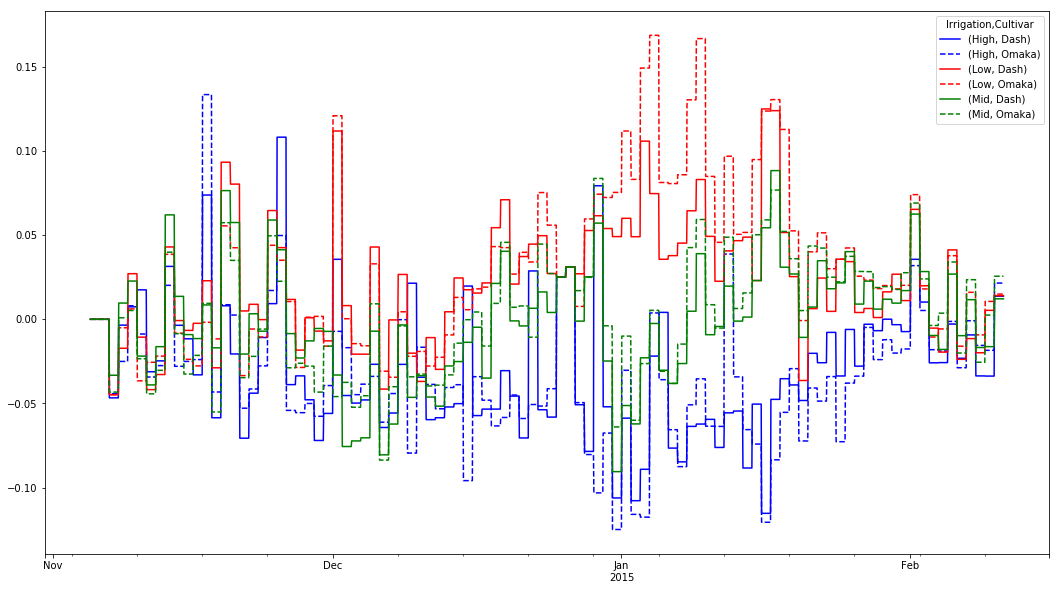

In [160]:
UpwardFluxHourlyArray = np.divide(UpwardFlux.values,24)
UpwardFluxHourly = pd.DataFrame(data = UpwardFluxHourlyArray,index=UpwardFlux.index,columns=UpwardFlux.columns)
UpwardFluxHourly = UpwardFluxHourly.resample('h').bfill()
MeanUpwardFluxHourly = UpwardFluxHourly.groupby(level=['Irrigation', 'Cultivar'],axis=1).mean()
MeanUpwardFluxHourly.plot( figsize=(18,10), style=['b-','b--','r-','r--','g-','g--'])

(-0.5, 0.2)

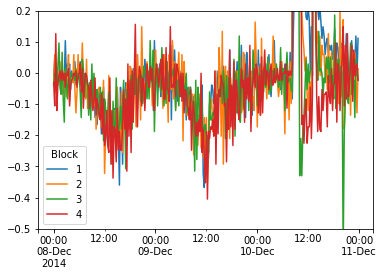

In [161]:
WaterDelta.loc['2014-12-08':'2014-12-10',('Omaka','High')].plot()
plt.ylim(-.5,.2)

(-0.5, 0.2)

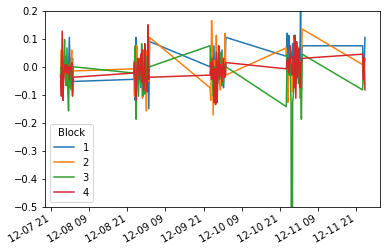

In [162]:
WaterDelta.iloc[WaterDelta.index.indexer_between_time(datetime.time(23),datetime.time(4))].loc['2014-12-08':'2014-12-11',('Omaka','High')].plot()
plt.ylim(-.5,.2)

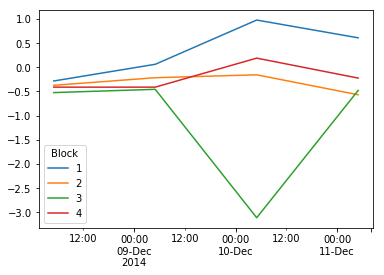

In [163]:
DarkWaterDeltas.loc['2014-12-08':'2014-12-11',('Omaka','High')].plot()
#plt.ylim(-.5,.2)

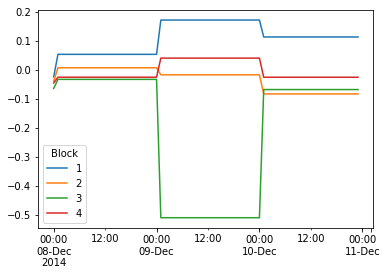

In [164]:
UpwardFluxHourly.loc['2014-12-08':'2014-12-10',('Omaka','High')].plot()

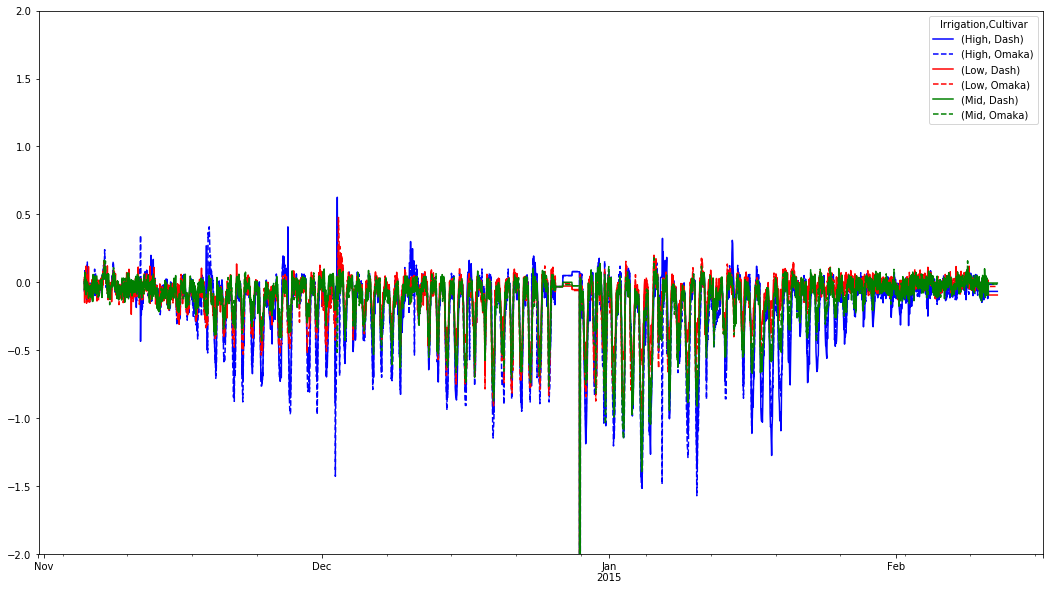

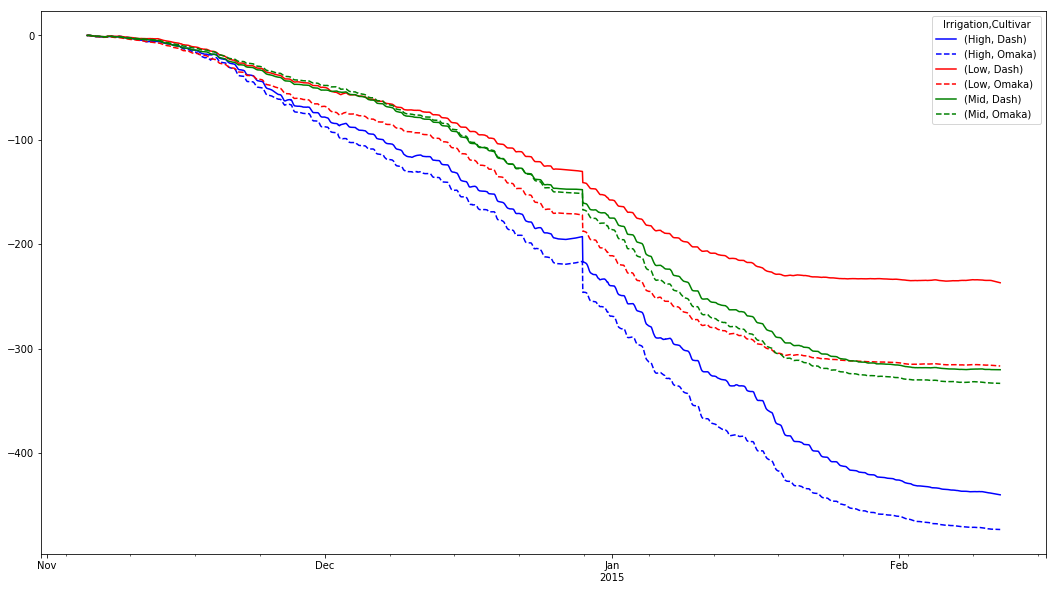

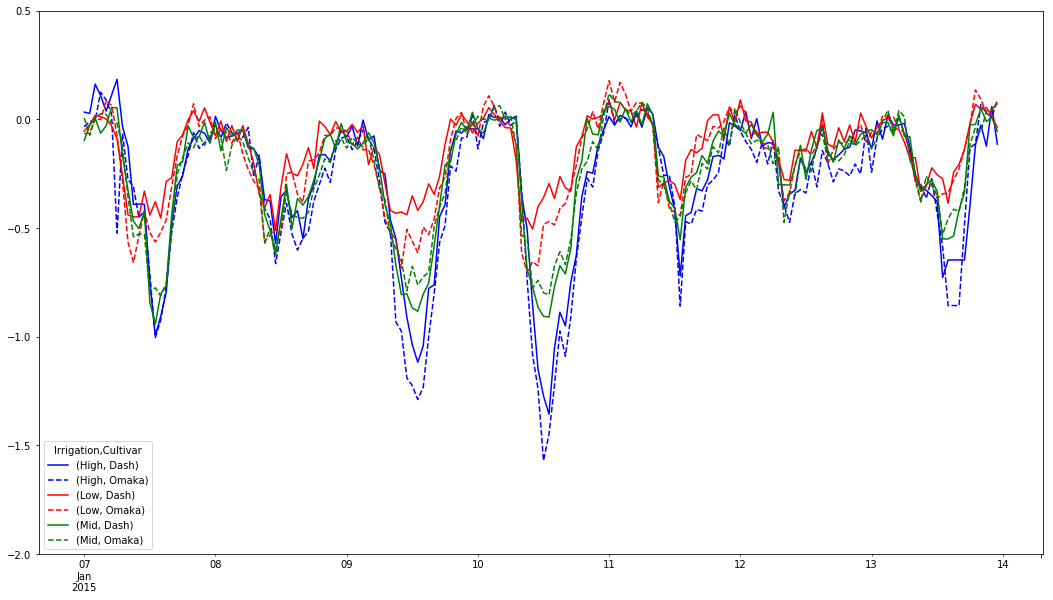

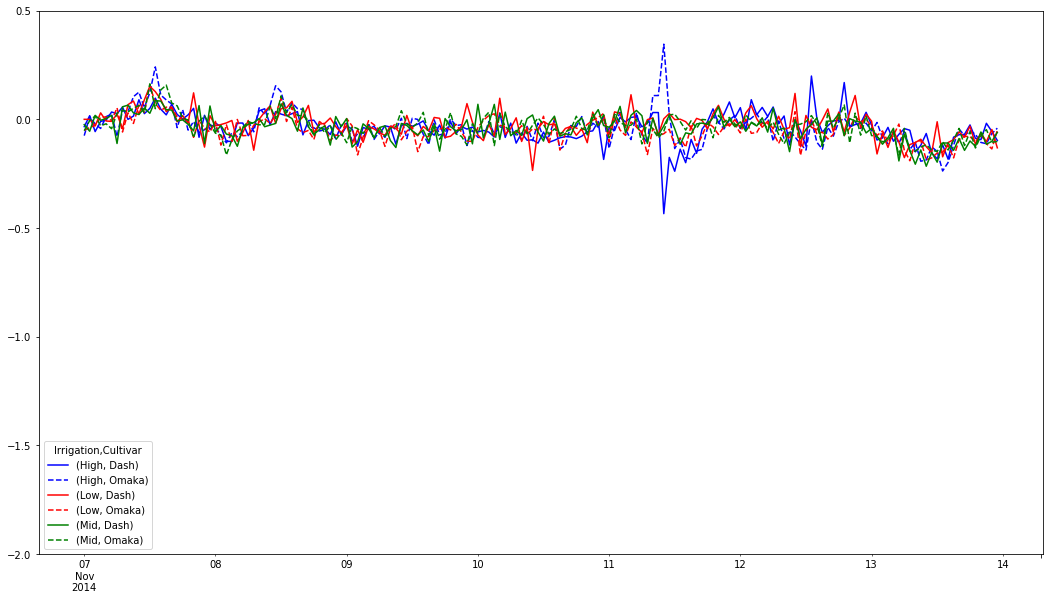

In [165]:
WaterUseHourly = WaterDeltaHourly.subtract(UpwardFluxHourly)
WaterUseHourly = WaterUseHourly.where(WaterUseHourly<1)
WaterUseHourly.fillna(method='ffill', inplace = True)
MeanWaterUseHourly = WaterUseHourly.groupby(level=['Irrigation', 'Cultivar'],axis=1).mean()
MeanWaterUseHourly.plot(figsize=(18,10),style=['b-','b--','r-','r--','g-','g--'], ylim=(-2,2))
MeanWaterUseHourly.cumsum().plot(figsize=(18,10),style=['b-','b--','r-','r--','g-','g--'])
MeanWaterUseHourly.loc['2015-01-07':'2015-01-13'].plot(figsize=(18,10),style=['b-','b--','r-','r--','g-','g--'], ylim=(-2,0.5))
MeanWaterUseHourly.loc['2014-11-07':'2014-11-13'].plot(figsize=(18,10),style=['b-','b--','r-','r--','g-','g--'], ylim=(-2,0.5))

In [166]:
WaterUseHourly.to_pickle('.\DataFrames\HourlyWUmm.pkl')

## Calculate Daily Water Use

In [167]:
#Set up daily water use sums
WaterUseDaily = WaterUseHourly.resample('D').sum()
WaterUseDaily.index.name = 'Date'

#Wipe the data on the days when the data logger was full
WaterUseDaily.loc['2014-12-26':'2014-12-28',:] = np.nan

#wipe the data on the days when irrigation occured 
WaterUseDaily.loc[LowIrrIndex,'Low']=np.nan
for date in MidIrrIndex:
    WaterUseDaily.loc[date,'Mid']=np.nan
for date in HighIrrigIndex:
    WaterUseDaily.loc[date,'High']=np.nan


In [168]:
#calculate treatment means
WaterUseDailyMeans = WaterUseDaily.groupby(level=['Irrigation', 'Cultivar'],axis=1).mean()
#Make water use positive
WaterUseDailyMeans = WaterUseDailyMeans.multiply(-1)
#Remove the 28th of December because data was lost from the previous two days meaning these days water use was moved into the 28th
WaterUseDailyMeans.loc['2014-12-25':'2014-12-28'] = np.nan

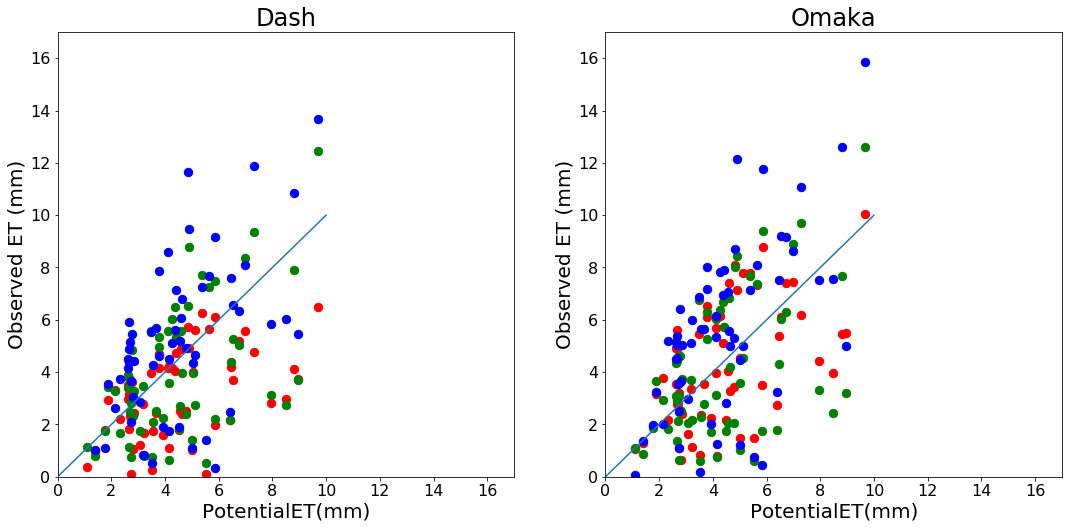

In [169]:
Comparison = plt.figure(figsize = (18,18))

Irrigations = ['Low','Mid','High']
Cultivars = ['Dash','Omaka']
Colors = ['red','green','blue']

Position = 1
for Cul in Cultivars:
    fig = Comparison.add_subplot(2,2,Position)
    ColorPosition = 0   
    for Irr in Irrigations:
        yData = WaterUseDailyMeans.loc['2014-11-08':'2015-01-10',(Irr,Cul)]
        plt.scatter(DayTimePET.loc['2014-11-08':'2015-01-10'],
                    yData, 
                    color = Colors[ColorPosition],
                    label = Irr,
                    s = 70)
        ColorPosition += 1
    plt.plot([0,10],[0,10],'-')
    plt.ylabel('Observed ET (mm)', fontsize= 20)
    plt.xlabel('PotentialET(mm)', fontsize= 20)
    plt.tick_params(labelsize = 16)
    plt.ylim(0,17)
    plt.xlim(0,17)
    #plt.legend(loc=1,fontsize = 24)
    plt.title(Cul, fontsize = 24)
    Position +=1

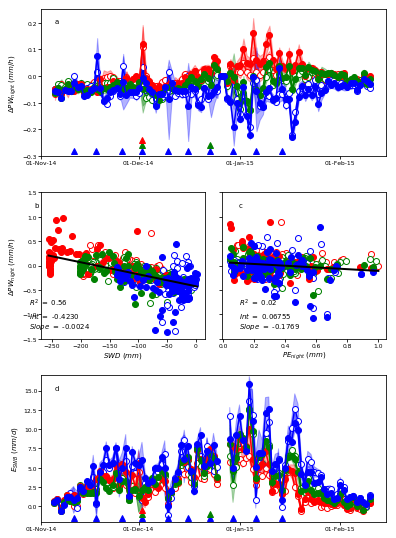

In [170]:
Graph = plt.figure(figsize=(5.6,10))

#Dark Water Delta graph
Cultivars = ['Dash','Omaka']
Irrigations = ['Low', 'Mid', 'High']
colors = ['r','b']
cultColors = ['w','w','w','r','g','b']
irrigColors = ['r','g','b','r','g','b']
alphas = [0.2,0.3]
fig = plt.subplot2grid((4,2),(0,0),colspan=2)
CulPos = 0
for Cul in Cultivars:
    IrrPos = 0
    for Irr in Irrigations:
        Ind = DarkWaterDeltas.loc[:'2015-02-10',(Cul,Irr)].index
        Med = DarkWaterDeltas.loc[:'2015-02-10',(Cul,Irr)].mean(axis=1)/6
        SEM = DarkWaterDeltas.loc[:'2015-02-10',(Cul,Irr)].std(axis=1)/np.sqrt(4)/6
        Upp = Med + SEM
        Low = Med - SEM
        plt.fill_between(Ind,Upp,Low,color = irrigColors[IrrPos],alpha=0.3)
        plt.plot(Ind,Med,'o-',mec=irrigColors[IrrPos], mfc = cultColors[CulPos],label = Cul + ' ' + Irr,color=irrigColors[IrrPos])
        IrrPos += 1
        CulPos+=1
plt.ylim(-.3,.25)
plt.plot(HighIrrigIndex,list(-0.28 for x in range(len(HighIrrigIndex))),'^',c='b')
plt.plot(MidIrrIndex,[-0.26,-0.26],'^',c='g')
plt.plot(LowIrrIndex,[-0.24],'^',c='r')
plt.xlim('2014-11-1','2015-02-15')
plt.ylabel('$\Delta PW_{night}$ $(mm/h)$', fontsize=7)
fig.xaxis.set_major_locator(mdates.MonthLocator())
fig.xaxis.set_major_formatter(mdates.DateFormatter('%d-%b-%y'))
plt.tick_params(axis='x', which='both', bottom=True,top=False, labelbottom=True,labelsize=6,length = 3, direction = 'out', pad = 1)
plt.tick_params(axis='y', which='both', left=True,right=False, labelright=False,labelsize=6, length = 3, direction = 'out', pad = 1)
plt.text('2014-11-05',0.2,'a',fontsize=7)

##Dark water delta vs SWD graph
#fig = Graph.add_subplot(4,2,3)
fig = plt.subplot2grid((4,2),(1,0))
ecols = ['r','g','b','r','g','b']
fcols = ['w','w','w','r','g','b']
DailyDescriptor = LongData.loc[:,'SWD']
pos = 0
for cul in Cultivars:
    for irr in Irrigations:
        fig.plot(LongData.loc[(cul,irr),'SWD'].loc['2014-11-08':],
            LongData.loc[(cul,irr),'DarkDeltas'].loc['2014-11-08':],
                 'o',mec=ecols[pos],mfc=fcols[pos])
        pos+=1  

X = LongData.loc[:,'SWD']
Y = LongData.loc[:,'DarkDeltas']
ModTemp = sm.regression.linear_model.OLS(Y,  # Y variable
                                        sm.add_constant(X), # X variable
                                        missing='drop',                                     # ignor and data where one value is missing
                                        hasconst=False) 
Regres = ModTemp.fit(); 
Xs = []
Xs.append(X.min())
Xs.append(X.max())
Ys = []
Ys.append(Regres.params[0] + Xs[0]*Regres.params[1])
Ys.append(Regres.params[0] + Xs[1]*Regres.params[1])
fig.plot(Xs,Ys,'-', linewidth = 2, color='k')
fitR2 = r'$R^2\ =\ $' + str(Regres.rsquared)[:4] + '\n$Int\ =\ $' + str(Regres.params[0])[:7] + '\n$Slope\ =\ $' + str(Regres.params[1])[:7] 
fig.text(-290,-1.3,fitR2,fontsize=7)
fig.set_ylim(-1.5,1.5)
#fig.set_title(des, fontsize = 20)
plt.ylabel('$\Delta PW_{night}$ $(mm/h)$', fontsize=7)
plt.xlabel('$SWD$ $(mm)$', fontsize=7, weight='bold')
plt.text(-280,1.2,'b',fontsize=7)
plt.tick_params(axis='x', which='both', bottom=True,top=False, labelbottom=True,labelsize=6,length = 3, direction = 'out', pad = 1)
plt.tick_params(axis='y', which='both', left=True,right=False, labelright=False,labelsize=6, length = 3, direction = 'out', pad = 1)
fig.xaxis.labelpad = 2

##Dark water delta residues vs dark PET graph
#fig = Graph.add_subplot(4,2,4)
fig = plt.subplot2grid((4,2),(1,1))
ecols = ['r','g','b','r','g','b']
fcols = ['w','w','w','r','g','b']
pos = 0
for cul in Cultivars:
    for irr in Irrigations:
        fig.plot(LongData.loc[(cul,irr),'PETnight'].loc['2014-11-08':],
            LongData.loc[(cul,irr),'ResDarkDeltas'].loc['2014-11-08':],
                 'o',mec=ecols[pos],mfc=fcols[pos])
        pos+=1  

X = LongData.loc[:,'PETnight']
Y = LongData.loc[:,'ResDarkDeltas']
ModTemp = sm.regression.linear_model.OLS(Y,  # Y variable
                                        sm.add_constant(X), # X variable
                                        missing='drop',                                     # ignor and data where one value is missing
                                        hasconst=False) 
Regres = ModTemp.fit(); 
Xs = []
Xs.append(X.min())
Xs.append(X.max())
Ys = []
Ys.append(Regres.params[0] + Xs[0]*Regres.params[1])
Ys.append(Regres.params[0] + Xs[1]*Regres.params[1])
fig.plot(Xs,Ys,'-', linewidth = 2, color='k')
fitR2 = r'$R^2\ =\ $' + str(Regres.rsquared)[:4] + '\n$Int\ =\ $' + str(Regres.params[0])[:7] + '\n$Slope\ =\ $' + str(Regres.params[1])[:7] 
fig.text(0.1,-1.3,fitR2,fontsize=7)
fig.set_ylim(-1.5,1.5)
#fig.set_title(des, fontsize = 20)
#plt.ylabel('$\Delta PW_{night}$ $(mm/h)$', fontsize=7, weight='bold')
plt.xlabel('$PE_{night}$ $(mm)$', fontsize=7, weight='bold')
plt.text(.1,1.2,'c',fontsize=7)
plt.tick_params(axis='x', which='both', bottom=True,top=False, labelbottom=True,labelsize=6,length = 3, direction = 'out', pad = 1)
plt.tick_params(axis='y', which='both', left=True,right=False, labelleft=False, labelright=False,labelsize=6, length = 3, direction = 'out', pad = 1)
fig.xaxis.labelpad = 2

#Latent heat flux Plot
fig = plt.subplot2grid((4,2),(2,0),colspan=2)
CulPos = 0
for Cul in Cultivars:
    IrrPos = 0
    for Irr in Irrigations:
        Ind = WaterUseDaily.loc[:'2015-02-10',(Cul,Irr)].index
        Med = WaterUseDaily.loc[:'2015-02-10',(Cul,Irr)].mean(axis=1)*-1
        SEM = WaterUseDaily.loc[:'2015-02-10',(Cul,Irr)].std(axis=1)/np.sqrt(4)
        Upp = Med + SEM
        Low = Med - SEM
        plt.fill_between(Ind,Upp,Low,color = irrigColors[IrrPos],alpha=0.3)
        plt.plot(Ind,Med,'o-',mec=irrigColors[IrrPos], mfc = cultColors[CulPos],label = Cul + ' ' + Irr,color=irrigColors[IrrPos])
        IrrPos += 1
        CulPos+=1
plt.ylim(-2,17)
plt.plot(HighIrrigIndex,list(-1.5 for x in range(len(HighIrrigIndex))),'^',c='b')
plt.plot(MidIrrIndex,[-1,-1],'^',c='g')
plt.plot(LowIrrIndex,[-0.5],'^',c='r')
plt.xlim('2014-11-1','2015-02-15')
plt.ylabel('$E_{SWB}$ $(mm/d)$', fontsize=7, weight='bold')
fig.xaxis.set_major_locator(mdates.MonthLocator())
fig.xaxis.set_major_formatter(mdates.DateFormatter('%d-%b-%y'))
plt.tick_params(labelsize=7)    
plt.text('2014-11-05',15,'d',fontsize=7)
plt.tick_params(axis='x', which='both', bottom=True,top=False, labelbottom=True,labelsize=6,length = 3, direction = 'out', pad = 1)
plt.tick_params(axis='y', which='both', left=True,right=False, labelright=False,labelsize=6, length = 3, direction = 'out', pad = 1)
plt.tight_layout()

Graph.savefig('Fig_5.jpg',dpi=1000)
        


(-2, 1)

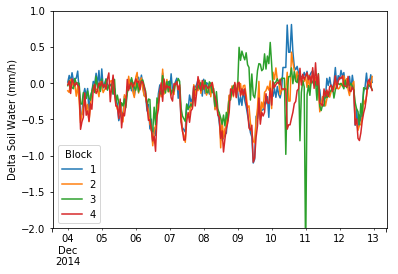

In [171]:
WaterUseHourly.loc['2014-12-04':'2014-12-12',('Omaka','High')].plot()
plt.ylabel('Delta Soil Water (mm/h)')
plt.ylim(-2,1)

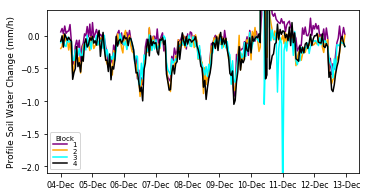

In [172]:
data = WaterDeltaHourly.loc['2014-12-04':'2014-12-12',('Omaka','High')]
BlockColors = ['purple','orange','cyan','k']
fig, ax = plt.subplots(figsize=(5.6,3))
BlockPos = 0
for b in data.columns:
    Ind = data.loc[:,b].index
    Med = data.loc[:,b]
    plt.plot(Ind,Med,'-',color = BlockColors[BlockPos],label = b)
    BlockPos+=1

plt.ylabel('Profile Soil Water Change (mm/h)',fontsize=9)
ax.xaxis.set_major_locator(mdates.HourLocator(0))
ax.xaxis.set_major_formatter(mdates.DateFormatter('%d-%b'))
plt.tick_params(labelsize=8)
plt.ylim(-2.1,0.4)

ledg = plt.legend(loc=3,numpoints=1,fontsize = 7,labelspacing = 0.05, 
                          title='Block')
ledg.get_title().set_fontsize(7)
plt.savefig('Fig_$.jpg',dpi=1000)